# Compare sea surface height model output and observations

Comparing the sea-surface height (ssh) from two different resolution runs. Specifically, we plot the time-mean and standard deviation of ssh and compare it to those obtained from observations from the CMEMS satellite altimetry dataset (former AVISO+ dataset).

In [1]:
import matplotlib.pyplot as plt
import intake
import numpy as np
import glob

import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm

from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44693,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:33105,Total threads: 4
Dashboard: /proxy/46299/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:34761,


Here we pick a `start_time` and `end_time`. We select *only* 5 years of daily data for computational speed in this example. But you can probably extend the `end_time` until the end of 2018 (for model outputs) and up to middle of 2020 for observations.

In [3]:
# SSH variable in ACCESS-OM2 models
variable = 'sea_level'

start_time = '1993-01-01'
end_time = '1997-12-31'

## SSH from 1$^{\circ}$ model output

In [4]:
catalog = intake.cat.access_nri

In [5]:
var_search = catalog['1deg_jra55_iaf_omip2_cycle6'].search(variable=variable, frequency='1day')
ds = var_search.to_dask()
ssh1 = ds[variable].sel(time=slice(start_time, end_time))

## SSH from 0.25$^{\circ}$ model output

In [6]:
var_search = catalog['025deg_jra55_iaf_omip2_cycle6'].search(variable=variable, frequency='1day')
ds = var_search.to_dask()
ssh025 = ds[variable].sel(time=slice(start_time, end_time))
ssh025

<xarray.DataArray 'sea_level' (time: 1826, yt_ocean: 1080, xt_ocean: 1440)> Size: 11GB
dask.array<getitem, shape=(1826, 1080, 1440), dtype=float32, chunksize=(1, 216, 240), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 15kB 1993-01-01T12:00:00 ... 1997-12-31T1...
Attributes:
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_height_above_geoid

You can see we have a very large number of chunks, so lets rechunk.

In [7]:
ssh025 = ssh025.chunk({'time':'auto'})

## CMEMS satellite observational data (former AVISO+ dataset)

Load the CMEMS dataset and select `adt` the sea surface height variable name.

**Note**: You **need** to join project `ua8` on NCI to access the CMEMS data!

In [8]:
filenames = glob.glob("/g/data/ua8/CMEMS_SeaLevel/timeseries/*.nc")
cmems = xr.open_mfdataset(filenames, parallel=True)

obs_ssh = cmems.adt
obs_ssh = obs_ssh.sel(time=slice(start_time, end_time))
obs_ssh = obs_ssh.rename('adt_cmems')

Compute the mean and standard deviations to plot. We add `.load()` so to enforce computations. For the `std` calculations we provide `skipna=False` option to tell xarray to ignore the points on land that have `NaN` values. This way it doesn't try to divide by a zero-length series while computing the standard deviation. (If we didn't provide`skipna=False` we'd get the same answer but with a bunch of `RuntimeWarnings`.)

**Note**: The following cells might take a while, depending how much data you loaded. (For 5 years of daily data ~3min for 0.25 model output using 28 cpus).

In [9]:
%%time
ssh1_mean = ssh1.mean(dim='time').load()
ssh1_std  = ssh1.std(dim='time', skipna=False).load()

CPU times: user 7.49 s, sys: 650 ms, total: 8.14 s
Wall time: 8.82 s


In [10]:
%%time
ssh025_mean = ssh025.mean(dim='time').load()
ssh025_std  = ssh025.std(dim='time', skipna=False).load()

CPU times: user 2min 30s, sys: 6.63 s, total: 2min 37s
Wall time: 2min 42s


In [11]:
%%time
obs_ssh_mean = obs_ssh.mean(dim='time').load()
obs_ssh_std  = obs_ssh.std(dim='time', skipna=False).load()

CPU times: user 2min, sys: 7.61 s, total: 2min 8s
Wall time: 2min 12s


## Plot and compare

Plot the time-mean and standard deviation of both of the model outputs and the CMEMS observational dataset (former AVISO+).

In [12]:
# load geolon_t/geolat_t, so we can plot the tripole correctly for the model output:

# 1 deg:
var_search = catalog['1deg_jra55_iaf_omip2_cycle6'].search(variable="area_t")
ds = var_search.search(path=var_search.df["path"][0]).to_dask()
geolon_t_1 = ds.geolon_t
geolat_t_1 = ds.geolat_t

ssh1_mean = ssh1_mean.assign_coords({"geolon_t": geolon_t_1, "geolat_t": geolat_t_1})
ssh1_std = ssh1_std.assign_coords({"geolon_t": geolon_t_1, "geolat_t": geolat_t_1})

# 0.25 deg:
var_search = catalog['025deg_jra55_iaf_omip2_cycle6'].search(variable="area_t")
ds = var_search.search(path=var_search.df["path"][0]).to_dask()
geolon_t_025 = ds.geolon_t
geolat_t_025 = ds.geolat_t

ssh025_mean = ssh025_mean.assign_coords({"geolon_t": geolon_t_025, "geolat_t": geolat_t_025})
ssh025_std = ssh025_std.assign_coords({"geolon_t": geolon_t_025, "geolat_t": geolat_t_025})

This plotting is a little slow, takes ~1 minute:

CPU times: user 1min 8s, sys: 101 ms, total: 1min 8s
Wall time: 1min 8s


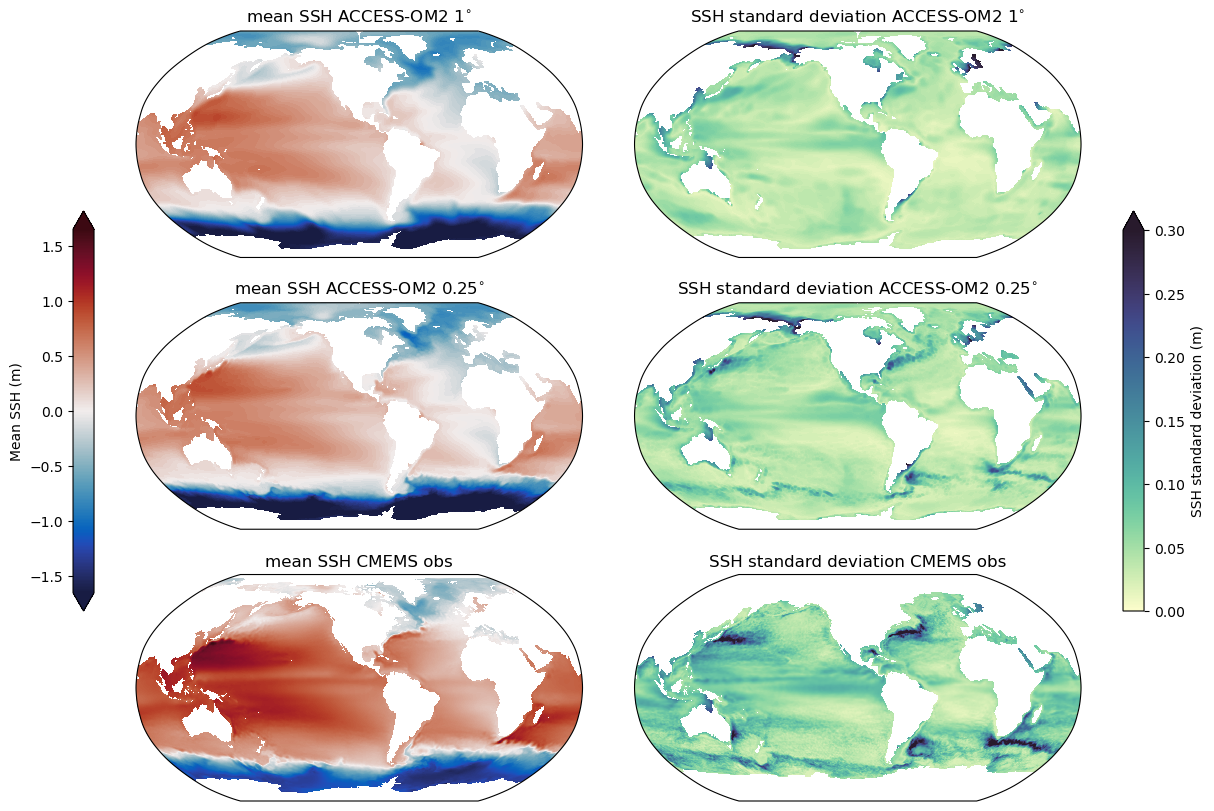

In [21]:
%%time

projection = ccrs.Robinson(central_longitude=-100)

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (14, 10),
                         subplot_kw={'projection': projection})
plt.subplots_adjust(wspace=-0.15)

max_std = 0.3
max_mean = 1.65

# mean SSH plots
ax = axes[0, 0]
p1 = ssh1_mean.plot.contourf(
    ax = ax,
    x = "geolon_t",
    y = "geolat_t",
    levels = 100,
    vmin = -max_mean,
    vmax = max_mean,
    add_colorbar=False,
    cmap = cm.cm.balance,
    transform = ccrs.PlateCarree())
ax.set_title('mean SSH ACCESS-OM2 1$^{\circ}$')

ax = axes[1, 0]
p1 = ssh025_mean.plot.contourf(
    ax = ax,
    x = "geolon_t",
    y = "geolat_t",
    levels = 100,
    vmin = -max_mean,
    vmax = max_mean,
    add_colorbar=False,
    cmap = cm.cm.balance,
    transform = ccrs.PlateCarree())
ax.set_title('mean SSH ACCESS-OM2 0.25$^{\circ}$')

ax = axes[2, 0]
p1 = obs_ssh_mean.plot(ax=ax, transform=ccrs.PlateCarree(),
                       cmap=cm.cm.balance, vmin=-max_mean, vmax=max_mean, add_colorbar=False)
ax.set_title('mean SSH CMEMS obs')

# std SSH plots
ax = axes[0, 1]
p2 = ssh1_std.plot.contourf(
    ax = ax,
    x = "geolon_t",
    y = "geolat_t",
    levels = 100,
    vmin = 0,
    vmax = max_std,
    add_colorbar=False,
    cmap = cm.cm.deep,
    transform = ccrs.PlateCarree())
ax.set_title('SSH standard deviation ACCESS-OM2 1$^{\circ}$')

ax = axes[1, 1]
p2 = ssh025_std.plot.contourf(
    ax = ax,
    x = "geolon_t",
    y = "geolat_t",
    levels = 100,
    vmin = 0,
    vmax = max_std,
    add_colorbar=False,
    cmap = cm.cm.deep,
    transform = ccrs.PlateCarree())
ax.set_title('SSH standard deviation ACCESS-OM2 0.25$^{\circ}$')

ax = axes[2, 1]
p2 = obs_ssh_std.plot(ax=ax, transform=ccrs.PlateCarree(),
                      cmap=cm.cm.deep, vmin=0, vmax=max_std, add_colorbar=False)
ax.set_title('SSH standard deviation CMEMS obs')

# Colorbars
ax_cb1 = plt.axes([0.13, 0.3, 0.015, 0.4])
cb = plt.colorbar(p1, cax=ax_cb1, extend='both', label='Mean SSH (m)')
ax_cb1.yaxis.set_ticks_position('left')
ax_cb1.yaxis.set_label_position('left')

ax_cb2 = plt.axes([0.88, 0.3, 0.015, 0.4])
cb = plt.colorbar(p2, cax=ax_cb2, extend='max', label='SSH standard deviation (m)');

In [14]:
client.close()